# 유튜브 추천 시스템

참고

https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf

In [13]:
import pandas as pd 

In [14]:
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')

movie_ratings = pd.merge(movies, ratings, on='movieId')

# print(movie_ratings.head())

# x값으로 사용자 히스토리 (시청한 내역, 좋아요, 싫어요) 를 넣으면,
# y값으로 해당 사용자가 다음으로 볼 영상의 인덱스

In [15]:
import numpy as np

In [16]:
# 임의로 설정
# rating >= 3.0 좋아요
# rating < 3.0 싫어요

movie_ratings['movie_type'] = np.where(movie_ratings['rating'] >= 3, 'like', 'dislike')

# print(movie_ratings.head())

In [17]:
# userId, movieId 정수 인코딩
user_ids = movie_ratings['userId'].unique().tolist()
user_to_index = {x: i for i, x in enumerate(user_ids)}
index_to_user = {i: x for i, x in enumerate(user_ids)}

movie_ids = movie_ratings['movieId'].unique().tolist()
movie_to_index = {x: i for i, x in enumerate(movie_ids)}
index_to_movie = {i: x for i, x in enumerate(movie_ids)}

# print(user_to_index)
# print(movie_to_index)

In [18]:
movie_ratings['userId'] = movie_ratings['userId'].map(user_to_index)
movie_ratings['movieId'] = movie_ratings['movieId'].map(movie_to_index)

# print(movie_ratings.head())

In [19]:
# 사용자 별로 어떤 영상을 좋아했고, 싫어했고, 시청했는지
movie_list = movie_ratings.groupby(['userId', 'movie_type'])['movieId'].apply(list).reset_index()

title_list = movie_ratings.groupby(['userId'])['movieId'].apply(list).reset_index()

# print(movie_list)
# print(title_list)

In [20]:
# 사용자 별로 어떤 영상을 좋아했고, 싫어했는지
user_movie_list = movie_list.pivot(index='userId', columns='movie_type', values='movieId').reset_index()

# print(user_movie_list)

In [21]:
# 어떤 사용자가 아무런 영상도 보지 않았다면? -> NaN
# 결측치 값을 채워줄건데 -> dummy 영화id -> 9066
# 리스트 형태로 행들을 맞춰줄건데... fillna 함수는 list 형태로 채워줄 수가 없음...
# 결측치 값을 9066, lambda를 써서 [9066]
dummy_movie_id = 9066

user_movie_list.fillna(dummy_movie_id, inplace=True)
user_movie_list['like'] = user_movie_list['like'].apply(lambda x: x if type(x) is list else [x])
user_movie_list['dislike'] = user_movie_list['dislike'].apply(lambda x: x if type(x) is list else [x])

In [22]:
user_final_list = pd.merge(user_movie_list, title_list, how='left')

# print(user_final_list)

In [23]:
# x값(유저 히스토리) -> y값(유저가 다음으로 볼 영상의 인덱스값)
# 사용자가 마지막으로 좋아요를 누른 영화를 빼내서 y값으로 지정
user_final_list['predict_labels'] = user_final_list['like'].apply(lambda x: (x[-1]))
user_final_list['like'] = user_final_list['like'].apply(lambda x: (x[:-1]))

# print(user_final_list.head())

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
# 패딩해줍시다!
pm = pad_sequences(user_final_list['movieId'])
pl = pad_sequences(user_final_list['like'])
pd = pad_sequences(user_final_list['dislike'])

In [26]:
# 패딩된 길이대로 shape 지정
input_title = Input(shape=(2391, ))
input_liked = Input(shape=(1819, ))
input_disliked = Input(shape=(843, ))

# 영화 제목은 9067개 (movieId 0~9065, 결측치값 9066)
# 좋아하거나 싫어할 수 있는 영화도 9067개 (movieId 0~9065, 결측치값 9066)
# 혹시나 이것이 다른 경우가 있을 수도 있기에 임베딩 레이어를 각각 만들어줬습니다!
features_embedding_layer = Embedding(9067, 16, mask_zero=True)
labels_embedding_layer = Embedding(9067, 16, mask_zero=True)

dense_1 = Dense(units=48, activation='relu')
dense_2 = Dense(units=48, activation='relu')
dense_3 = Dense(units=48, activation='relu')

# 총 9067개의 y값이 존재할 수 있으므로 (movieId 0~9065, 결측치값 9066)
dense_output = Dense(9067, activation='softmax')

In [27]:
# reduce mean axis=1 을 하면 데이터길이 축을 따라서 평균을 낸다
# 그러면 (671, 2391, 16) = (데이터개수, 데이터길이, 임베딩된 차원)
# 에서 (671, 16) = 각 데이터들이 16짜리 임베딩 벡터로 표현된 것
# 각 유저에 대해서 좋아하는 영화끼리 평균 / 싫어하는 영화끼리 평균 / 시청한 영화끼리 평균한 것
features_embeddings = features_embedding_layer(input_title)
avg_features = tf.reduce_mean(features_embeddings, axis=1)

labels_liked_embeddings = labels_embedding_layer(input_liked)
avg_liked = tf.reduce_mean(labels_liked_embeddings, axis=1)

labels_disliked_embeddings = labels_embedding_layer(input_disliked)
avg_disliked = tf.reduce_mean(labels_disliked_embeddings, axis=1)

# 세 개 다 (671, 16) 형태로 reduce_mean 되었으니 결합하면 (671, 48) 이 될 것!
concat_inputs = Concatenate()([avg_features, avg_liked, avg_disliked])

dense_1_out = dense_1(concat_inputs)
dense_2_out = dense_2(dense_1_out)
dense_3_out = dense_3(dense_2_out)
dense_3_batch_norm = BatchNormalization()(dense_3_out)
outputs = dense_output(dense_3_batch_norm)

In [28]:
model = Model([input_title, input_liked, input_disliked], outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit([pm, pl, pd], user_final_list['predict_labels'].values, epochs=100)

Train on 671 samples
Epoch 1/100
671/671 [==============================] - 2s 3ms/sample - loss: 9.1076 - acc: 0.0298
Epoch 2/100
671/671 [==============================] - 1s 1ms/sample - loss: 9.0565 - acc: 0.0492
Epoch 3/100
671/671 [==============================] - 1s 1ms/sample - loss: 8.8817 - acc: 0.0477
Epoch 4/100
671/671 [==============================] - 1s 972us/sample - loss: 8.5120 - acc: 0.0462
Epoch 5/100
608/671 [==========================>...] - ETA: 0s - loss: 8.0384 - acc: 0.042671/671 [==============================] - 1s 1ms/sample - loss: 8.0107 - acc: 0.0462
Epoch 6/100
671/671 [==============================] - 1s 1ms/sample - loss: 7.4193 - acc: 0.0462
Epoch 7/100
671/671 [==============================] - 1s 978us/sample - loss: 6.7826 - acc: 0.0477
Epoch 8/100
671/671 [==============================] - 1s 1ms/sample - loss: 6.2010 - acc: 0.0522
Epoch 9/100
608/671 [==========================>...] - ETA: 0s - loss: 5.8303 - acc: 0.054671/671 [==============

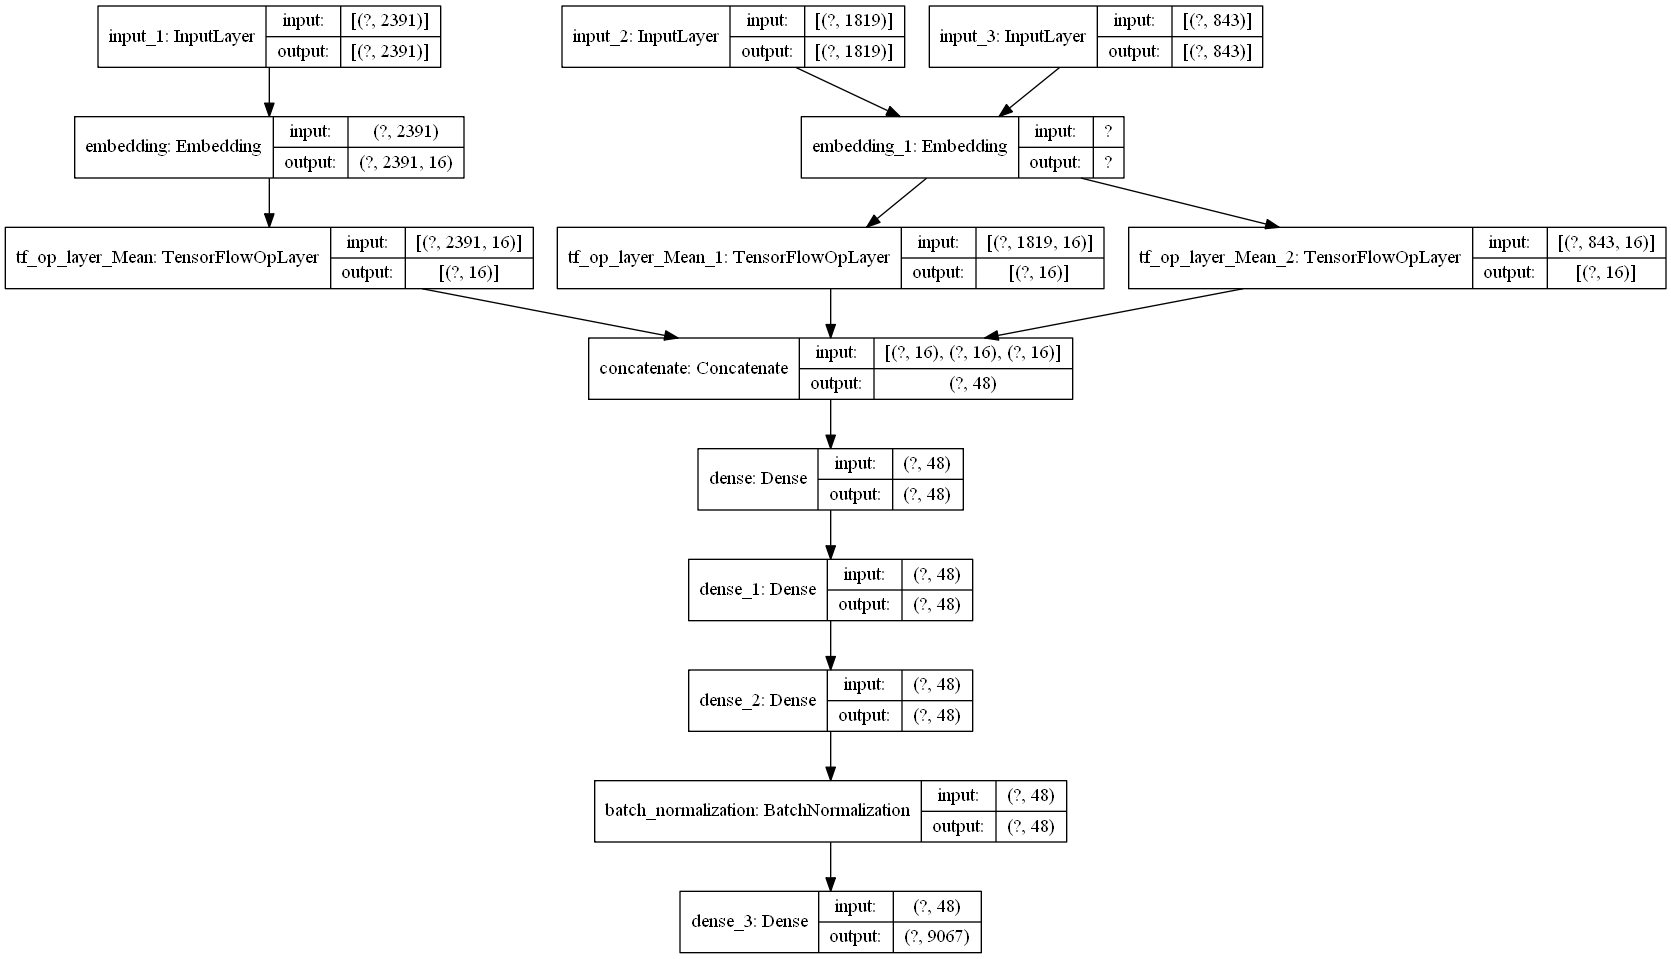

In [29]:
# 모델 구조도
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)